In [119]:
import pandas as pd
import pdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [120]:
%config InlineBackend.figure_format = 'retina'

In [121]:
import numpy as np
import scipy.ndimage
from sklearn.decomposition import PCA
import torch
import torch.nn as nn

def snv(data):
    """
    SNV normalization of the spectra

    data: unormalized spectra of size N x D
    idx: A 1-d boolean array of size D
         corresponding to the spectral range for normalization

    output: normalized data
    """
    subdata = data
    mean = subdata.mean(axis=1, keepdims=True)
    std = subdata.std(axis=1, keepdims=True)

    data_normalized = (data-mean)/std

    return data_normalized



def norris_2nd(data, segment, gap):
    """
    Norris second derivative filter

    data: noisy spectra of size N x D
    segment: length of averaging
    gap: gap for central differences
    Details: https://journals.sagepub.com/doi/10.1255/nirn.611

    output: filtered 2nd derivative spectra
    """

    filter = [np.ones(segment),
              np.zeros(gap),
              np.ones(segment) * -2,
              np.zeros(gap),
              np.ones(segment)]
    filter = np.hstack(filter)

    filtered_data = scipy.ndimage.convolve1d(data, filter, axis=1)

    # throw away begining and end
    starting_idx = segment + gap + (segment-1)//2
    filtered_data = filtered_data[:, starting_idx:-starting_idx]

    return filtered_data


def mahalanobis_train(data, label, num_classes, num_components):
    """
    Use training data to derive the mahalanobis distance to each class center

    data: spectra of size N x D
    label: label of size N, taking value in [0, ..., num_classes-1]
    num_classes: number of classes
    num_components: number of PC

    output: a list of PCAs of size num_classes
            output[i] = pca[i], which stores the class mean info
    """
    output = []
    for i in np.arange(num_classes):
        data_now = data[label==i, :]
        pca_now = PCA(n_components = num_components)
        pca_now.fit(data_now)
        output.append(pca_now)

    return output


def mahalanobis_calculate(data, pca_list):
    """
    Calculating the mahalanobis distance to class means

    data: spectra of size N x D
    pca_list: a list of PCA of size num_classes

    output: an array of size N x num_classes
            each entry is the mahalanobis distance to the class mean
    """

    num_classes = len(pca_list)
    N = data.shape[0]
    output = np.zeros([N, num_classes])

    for i in np.arange(num_classes):
        pca_now = pca_list[i]
        feature = pca_now.transform(data)
        normalized_feature = feature / pca_now.singular_values_
        distance_now = np.linalg.norm(normalized_feature, axis=1)
        output[:, i] = distance_now

    return output


def calculate_r2(y_pred, y_true):
    """
    Calculating R2
    """
    u = ((y_true - y_pred)** 2).sum()
    v = ((y_true - y_true.mean()) ** 2).sum()

    return 1-u/v

def calculate_RMSE(y_pred, y_true):
    """
    Calculating root mean square error
    """
    rmse = (((y_pred - y_true)**2).mean())**.5
    return rmse

In [122]:
#### Figure 2 classification analysis parameters ####
dim_hidden = 100 # num of hidden units in the neural network classifier
num_layers = 2 # num of hidden layers
num_epochs = 10000
ages = ['Day1', 'Day7', 'Day14', 'Day21']
num_classes = len(ages)

In [123]:
#### Load Figure 2 data for classification ####
loaded = np.load("data/Figure_2_classification.npz")

data_train = loaded["data_train"]
data_test = loaded["data_test"]
label_train = loaded["label_train"]
label_test = loaded["label_test"]
spectral_range = loaded["spectral_range"]

In [124]:
#### Figure 2 classification model ####
import torch
import numpy as np
from torch import nn

device = torch.device('cpu')

## data ##
data_train = torch.tensor(data_train, dtype=torch.float32).to(device)
data_test = torch.tensor(data_test, dtype=torch.float32).to(device)

label_train = torch.tensor(label_train, dtype=torch.int64).to(device)
label_test = torch.tensor(label_test, dtype=torch.int64).to(device)

## model ##
hidden = [nn.Linear(dim_hidden, dim_hidden), nn.ReLU()] * num_layers

feature_extractor = nn.Sequential(nn.Linear(data_train.shape[1], dim_hidden), nn.ReLU(), *hidden).to(device)

model = nn.Sequential(
    feature_extractor,
    nn.Linear(dim_hidden, num_classes)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

best_acc_test = 0.0  # Initialize the best test accuracy
best_model_state = None  # Placeholder for the best model state

## full-batch training
for epoch in np.arange(num_epochs):
    
    # compute prediction error
    pred = model(data_train)
    loss = loss_fn(pred, label_train)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 999:
        # training
        loss_train = loss.item()
        num_correct_train = (pred.argmax(1) == label_train).type(torch.float).sum().item()
        acc_train = num_correct_train / data_train.shape[0]
        
        # testing
        pred_test = model(data_test)
        num_correct_test = (pred_test.argmax(1) == label_test).type(torch.float).sum().item()
        acc_test = num_correct_test / data_test.shape[0]        

        # Save the best model
        if acc_test > best_acc_test:
            best_acc_test = acc_test
            best_model_state = model.state_dict()  # Save model's parameters

        print("Epoch = %d| Loss_train: %.4f | Acc_train: %.2f | Acc_test: %.2f" % (epoch, loss_train, acc_train, acc_test))

# Save the best model to a file
torch.save(best_model_state, "figure_2_classification_model.pth")

# Load the best model for evaluation (optional)
model.load_state_dict(torch.load("figure_2_classification_model.pth"))
model.eval()
with torch.no_grad():
    pred_test_last = model(data_test)
    label_test_last = label_test

Epoch = 999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.84
Epoch = 1999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.84
Epoch = 2999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.84
Epoch = 3999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.84
Epoch = 4999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.84
Epoch = 5999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.84
Epoch = 6999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.84
Epoch = 7999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.84
Epoch = 8999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.84
Epoch = 9999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.84


/var/folders/1n/d01xw0td6gs9hhffxkqqydy80000gn/T/ipykernel_53225/2495716551.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("figure_2_c

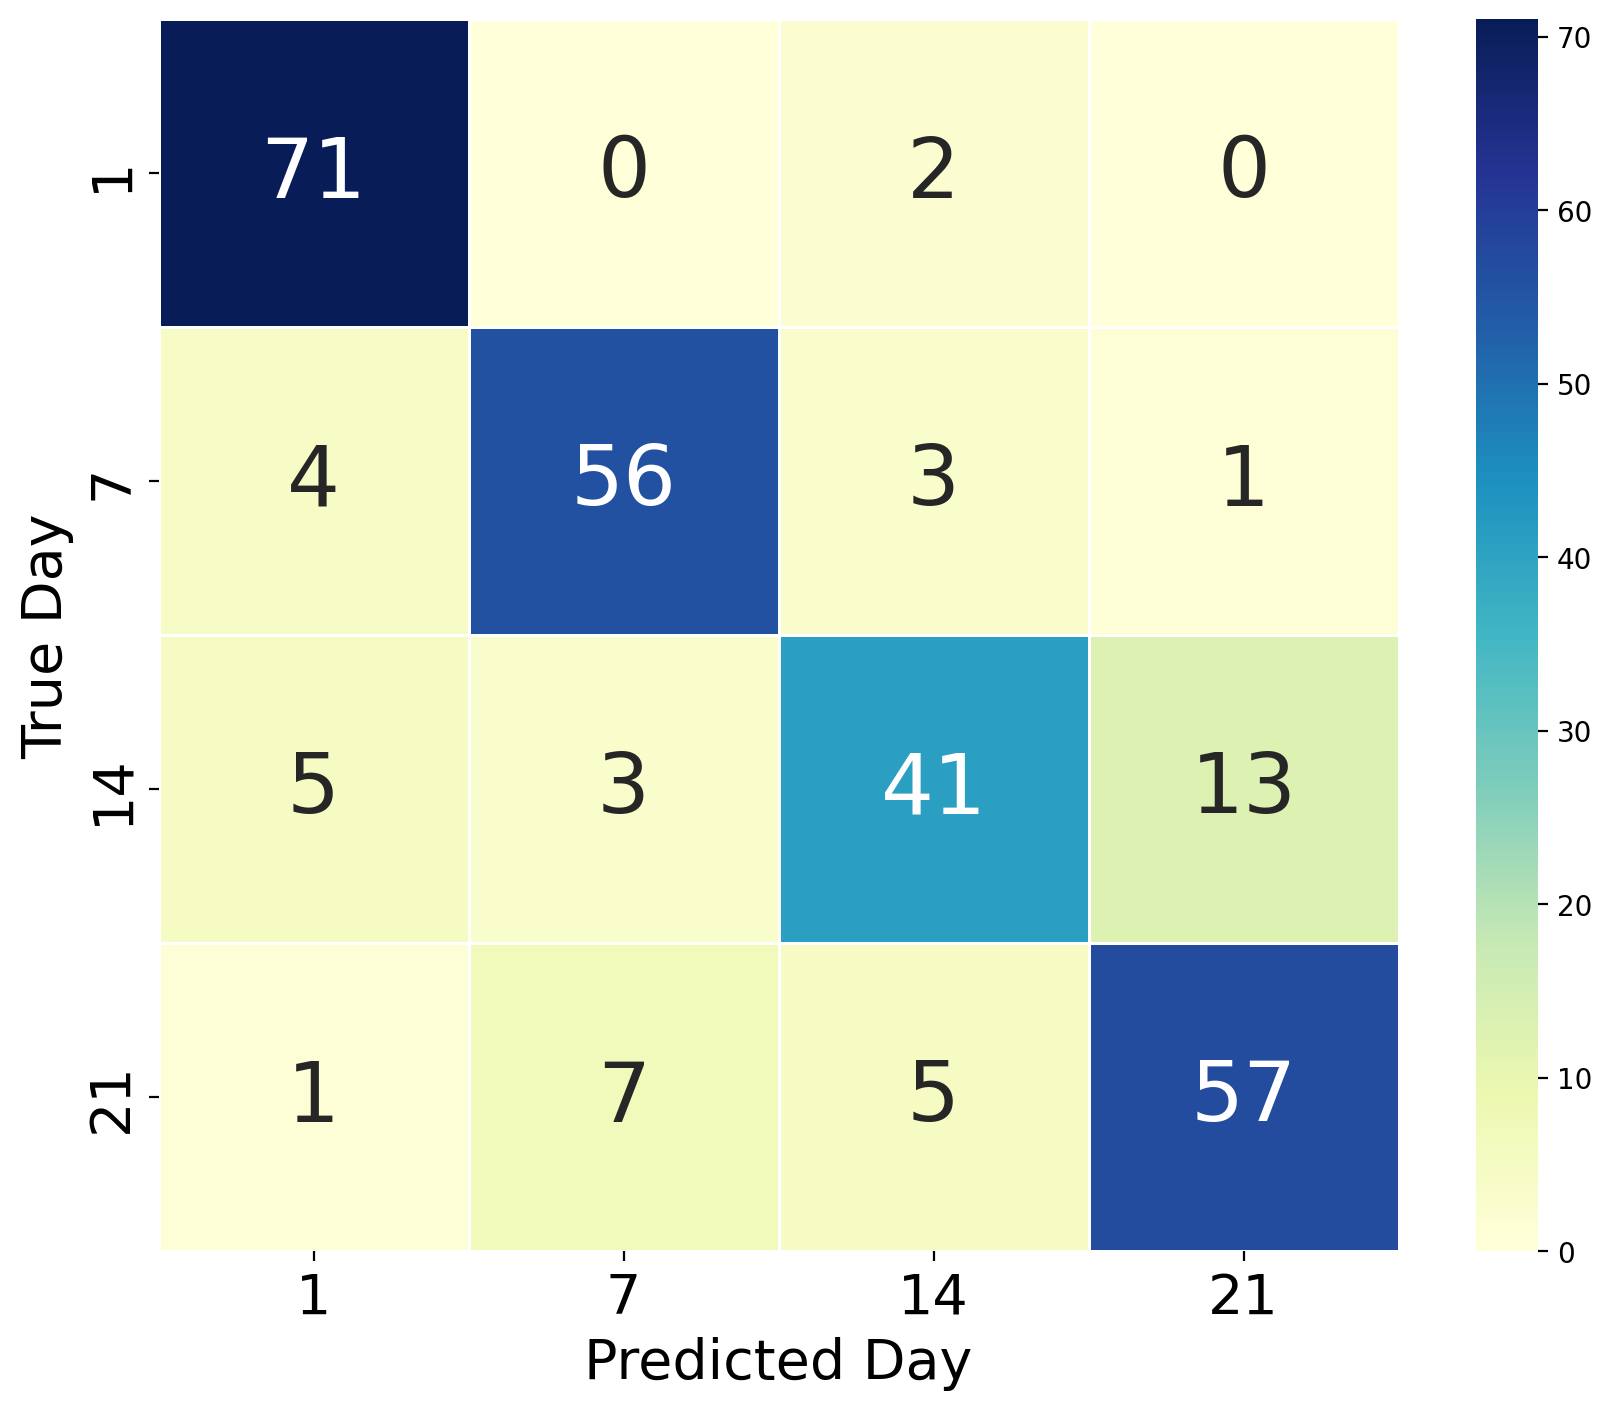

In [125]:
### Figure 2B ###
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Your existing code to get pred_labels and true_labels
pred_labels = pred_test_last.argmax(1).cpu().numpy()
true_labels = label_test_last.cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Define class labels (adjust this list to match your actual labels)
class_labels = [1, 7, 14, 21]
# Plot confusion matrix
plt.figure(figsize=(10, 8))
#sns.set(font_scale=1.5)  # Adjust to increase the size of the annotations
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=.5, 
            xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 30})
#sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=.5, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Day", fontsize=20)  # Adjust to increase the size of the x-axis label
plt.ylabel("True Day", fontsize=20)  # Adjust to increase the size of the y-axis label
plt.xticks(fontsize=20)  # Adjust to increase the size of x-axis tick labels
plt.yticks(fontsize=20)  # Adjust to increase the size of y-axis tick labels
plt.show()

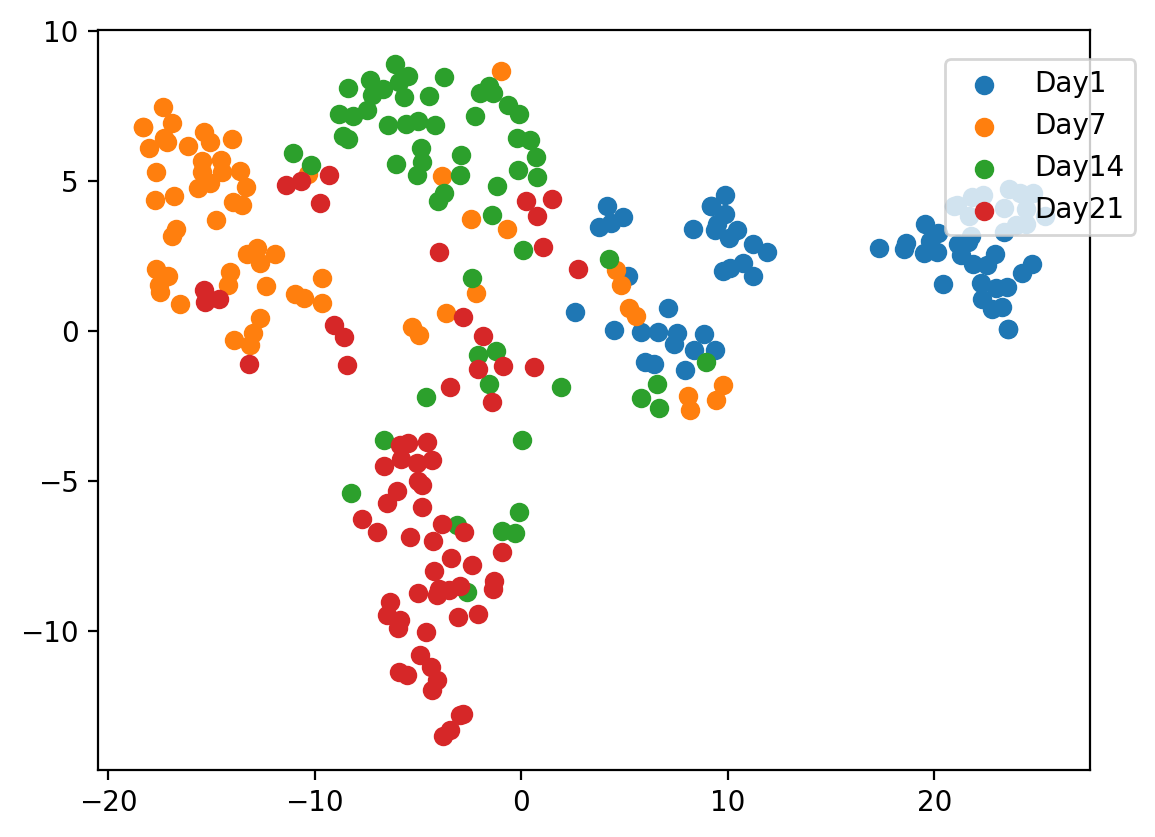

In [126]:
### Figure 2C ###
from sklearn.manifold import TSNE
with torch.no_grad():
    dnn_feature_test = feature_extractor(data_test).numpy()

# Set the number of components to 2 for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
feature_test_embedded_tsne = tsne.fit_transform(dnn_feature_test)

fig, ax = plt.subplots()
for ii in range(len(ages)):  # Adjust the range based on your labels
    idx = np.where(label_test == ii)
    feature_now = feature_test_embedded_tsne[idx[0]]
    ax.scatter(feature_now[:, 0], feature_now[:, 1], label=str(ages[ii]))

ax.legend()
plt.legend(loc='upper left', bbox_to_anchor=(0.84,0.98))
plt.show()


In [127]:
### Load Figure 2 data for regression ###
loaded = np.load("data/Figure_2_regression.npz")

data_train = loaded["data_train"]
data_test = loaded["data_test"]
label_train = loaded["label_train"]
label_test = loaded["label_test"]
spectral_range = loaded["spectral_range"]

In [128]:
#### Figure 2 regression model ####
device = torch.device('cpu')

## data ##
data_train = torch.tensor(data_train, dtype=torch.float32).to(device)
data_test = torch.tensor(data_test, dtype=torch.float32).to(device)

label_train = torch.tensor(label_train, dtype=torch.float32).to(device)
label_test = torch.tensor(label_test, dtype=torch.float32).to(device)

## model ##
hidden = [nn.Linear(dim_hidden, dim_hidden), nn.ReLU()] * num_layers
feature_extractor = nn.Sequential(nn.Linear(data_train.shape[1], dim_hidden), nn.ReLU(), *hidden).to(device)

model = nn.Sequential(
    feature_extractor,
    nn.Linear(dim_hidden, 1)
).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

## Initialize best model tracking
best_r2_test = -float('inf')
best_model_state = None

## full-batch training
for epoch in np.arange(num_epochs):
    
    pred = model(data_train).reshape(-1)
    loss = loss_fn(pred, label_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 999 or epoch == num_epochs - 1:
        # Train metrics
        loss_train = loss.item()
        R_train = (calculate_r2(pred, label_train).item())**0.5
        RMSE_train = calculate_RMSE(pred, label_train).item()

        # Test metrics
        pred_test = model(data_test).reshape(-1)
        R_test = (calculate_r2(pred_test, label_test).item())**0.5
        RMSE_test = calculate_RMSE(pred_test, label_test).item()

        print("Epoch = %d | Loss_train: %.4f | R_train: %.4f | RMSE_train: %.4f | R_test: %.4f | RMSE_test: %.4f" % (
            epoch, loss_train, R_train, RMSE_train, R_test, RMSE_test))

        # Save the best model by R²
        if R_test > best_r2_test:
            best_r2_test = R_test
            best_model_state = model.state_dict()

# Save best model
torch.save(best_model_state, "figure_2_regression_model.pth")

# Load best model for evaluation (optional)
model.load_state_dict(torch.load("figure_2_regression_model.pth"))
model.eval()
with torch.no_grad():
    pred_test_final = model(data_test).reshape(-1)
    actual_test_final = label_test

Epoch = 999 | Loss_train: 10.3277 | R_train: 0.9072 | RMSE_train: 3.2137 | R_test: 0.8254 | RMSE_test: 4.3898
Epoch = 1999 | Loss_train: 2.8476 | R_train: 0.9753 | RMSE_train: 1.6875 | R_test: 0.9246 | RMSE_test: 2.9615
Epoch = 2999 | Loss_train: 5.1381 | R_train: 0.9550 | RMSE_train: 2.2667 | R_test: 0.8788 | RMSE_test: 3.7110
Epoch = 3999 | Loss_train: 19.6357 | R_train: 0.8146 | RMSE_train: 4.4312 | R_test: 0.7987 | RMSE_test: 4.6781
Epoch = 4999 | Loss_train: 9.9707 | R_train: 0.9106 | RMSE_train: 3.1576 | R_test: 0.8729 | RMSE_test: 3.7936
Epoch = 5999 | Loss_train: 8.9490 | R_train: 0.9201 | RMSE_train: 2.9915 | R_test: 0.8740 | RMSE_test: 3.7780
Epoch = 6999 | Loss_train: 2.7188 | R_train: 0.9764 | RMSE_train: 1.6489 | R_test: 0.9320 | RMSE_test: 2.8185
Epoch = 7999 | Loss_train: 2.8467 | R_train: 0.9753 | RMSE_train: 1.6872 | R_test: 0.9280 | RMSE_test: 2.8961
Epoch = 8999 | Loss_train: 1.0234 | R_train: 0.9912 | RMSE_train: 1.0116 | R_test: 0.9432 | RMSE_test: 2.5834
Epoch = 9

/var/folders/1n/d01xw0td6gs9hhffxkqqydy80000gn/T/ipykernel_53225/882015246.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("figure_2_re

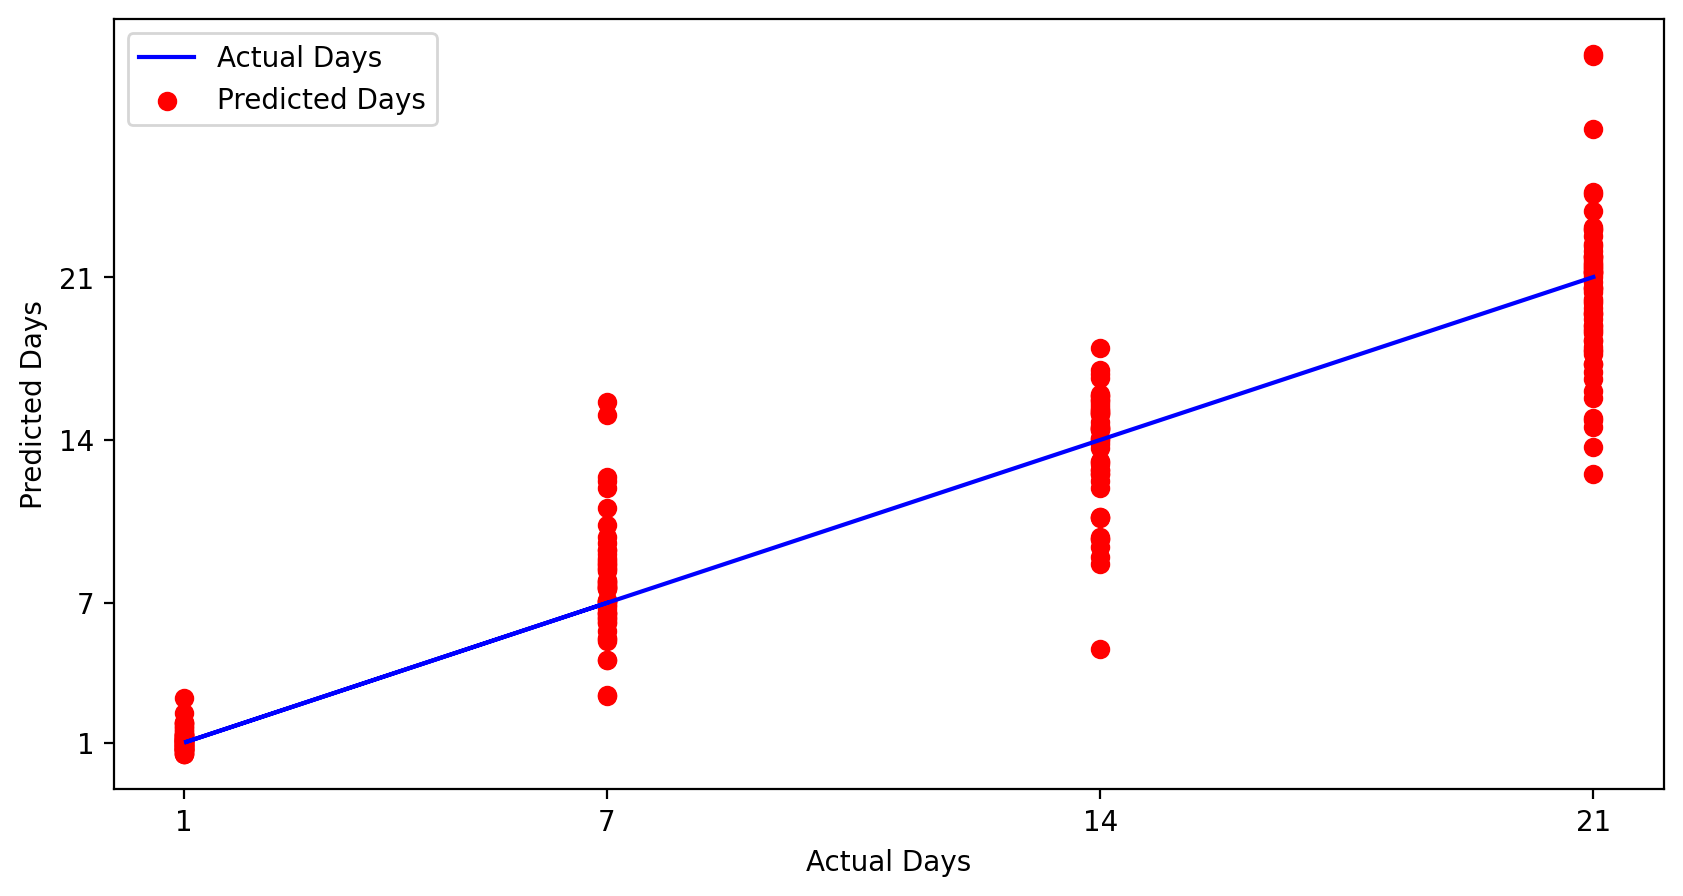

In [129]:
### Figure 2D ###
import pandas as pd
import matplotlib.pyplot as plt

# Convert tensors to NumPy arrays if needed
actual_np = actual_test_final.cpu().numpy()
predicted_np = pred_test_final.cpu().numpy()

# Create DataFrame
df_results = pd.DataFrame({
    'Actual Days': actual_np,
    'Predicted Days': predicted_np
})

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_results['Actual Days'], df_results['Actual Days'], label='Actual Days', linestyle='-', color='blue')
plt.scatter(df_results['Actual Days'], df_results['Predicted Days'], label='Predicted Days', color='red')
plt.xlabel('Actual Days')
plt.ylabel('Predicted Days')
plt.yticks([1, 7, 14, 21])
plt.xticks([1, 7,14, 21])
#plt.title('Actual vs Predicted Days for the Last Epoch')
plt.legend()
plt.show()

In [132]:
### Figure 3 classification data load ###
loaded = np.load("data/Figure_3_classification.npz")
data_train = loaded["data_train"]
data_test = loaded["data_test"]
label_train = loaded["label_train"]
label_test = loaded["label_test"]
spectral_range = loaded["spectral_range"]

In [133]:
#### Figure 3 classification analysis parameters ####
dim_hidden = 100 # num of hidden units in the neural network classifier
num_layers = 2 # num of hidden layers
num_epochs = 10000
ages = ['Day3', 'Day10', 'Day18']
num_classes = len(ages)

In [134]:
#### Figure 3 classification model ####
import torch
import numpy as np
from torch import nn

device = torch.device('cpu')

## data ##
data_train = torch.tensor(data_train, dtype=torch.float32).to(device)
data_test = torch.tensor(data_test, dtype=torch.float32).to(device)

label_train = torch.tensor(label_train, dtype=torch.int64).to(device)
label_test = torch.tensor(label_test, dtype=torch.int64).to(device)

## model ##
hidden = [nn.Linear(dim_hidden, dim_hidden), nn.ReLU()] * num_layers

feature_extractor = nn.Sequential(nn.Linear(data_train.shape[1], dim_hidden), nn.ReLU(), *hidden).to(device)

model = nn.Sequential(
    feature_extractor,
    nn.Linear(dim_hidden, num_classes)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

best_acc_test = 0.0  # Initialize the best test accuracy
best_model_state = None  # Placeholder for the best model state

## full-batch training
for epoch in np.arange(num_epochs):
    
    # compute prediction error
    pred = model(data_train)
    loss = loss_fn(pred, label_train)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 999:
        # training
        loss_train = loss.item()
        num_correct_train = (pred.argmax(1) == label_train).type(torch.float).sum().item()
        acc_train = num_correct_train / data_train.shape[0]
        
        # testing
        pred_test = model(data_test)
        num_correct_test = (pred_test.argmax(1) == label_test).type(torch.float).sum().item()
        acc_test = num_correct_test / data_test.shape[0]        

        # Save the best model
        if acc_test > best_acc_test:
            best_acc_test = acc_test
            best_model_state = model.state_dict()  # Save model's parameters

        print("Epoch = %d| Loss_train: %.4f | Acc_train: %.2f | Acc_test: %.2f" % (epoch, loss_train, acc_train, acc_test))

# Save the best model to a file
torch.save(best_model_state, "figure_3_classification_model.pth")

# Load the best model for evaluation (optional)
model.load_state_dict(torch.load("figure_3_classification_model.pth"))
model.eval()
with torch.no_grad():
    pred_test_last = model(data_test)
    label_test_last = label_test

Epoch = 999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.95
Epoch = 1999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.95
Epoch = 2999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.95
Epoch = 3999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.95
Epoch = 4999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.95
Epoch = 5999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.95
Epoch = 6999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.95
Epoch = 7999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.95
Epoch = 8999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.95
Epoch = 9999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.95


/var/folders/1n/d01xw0td6gs9hhffxkqqydy80000gn/T/ipykernel_53225/3268314943.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("figure_3_c

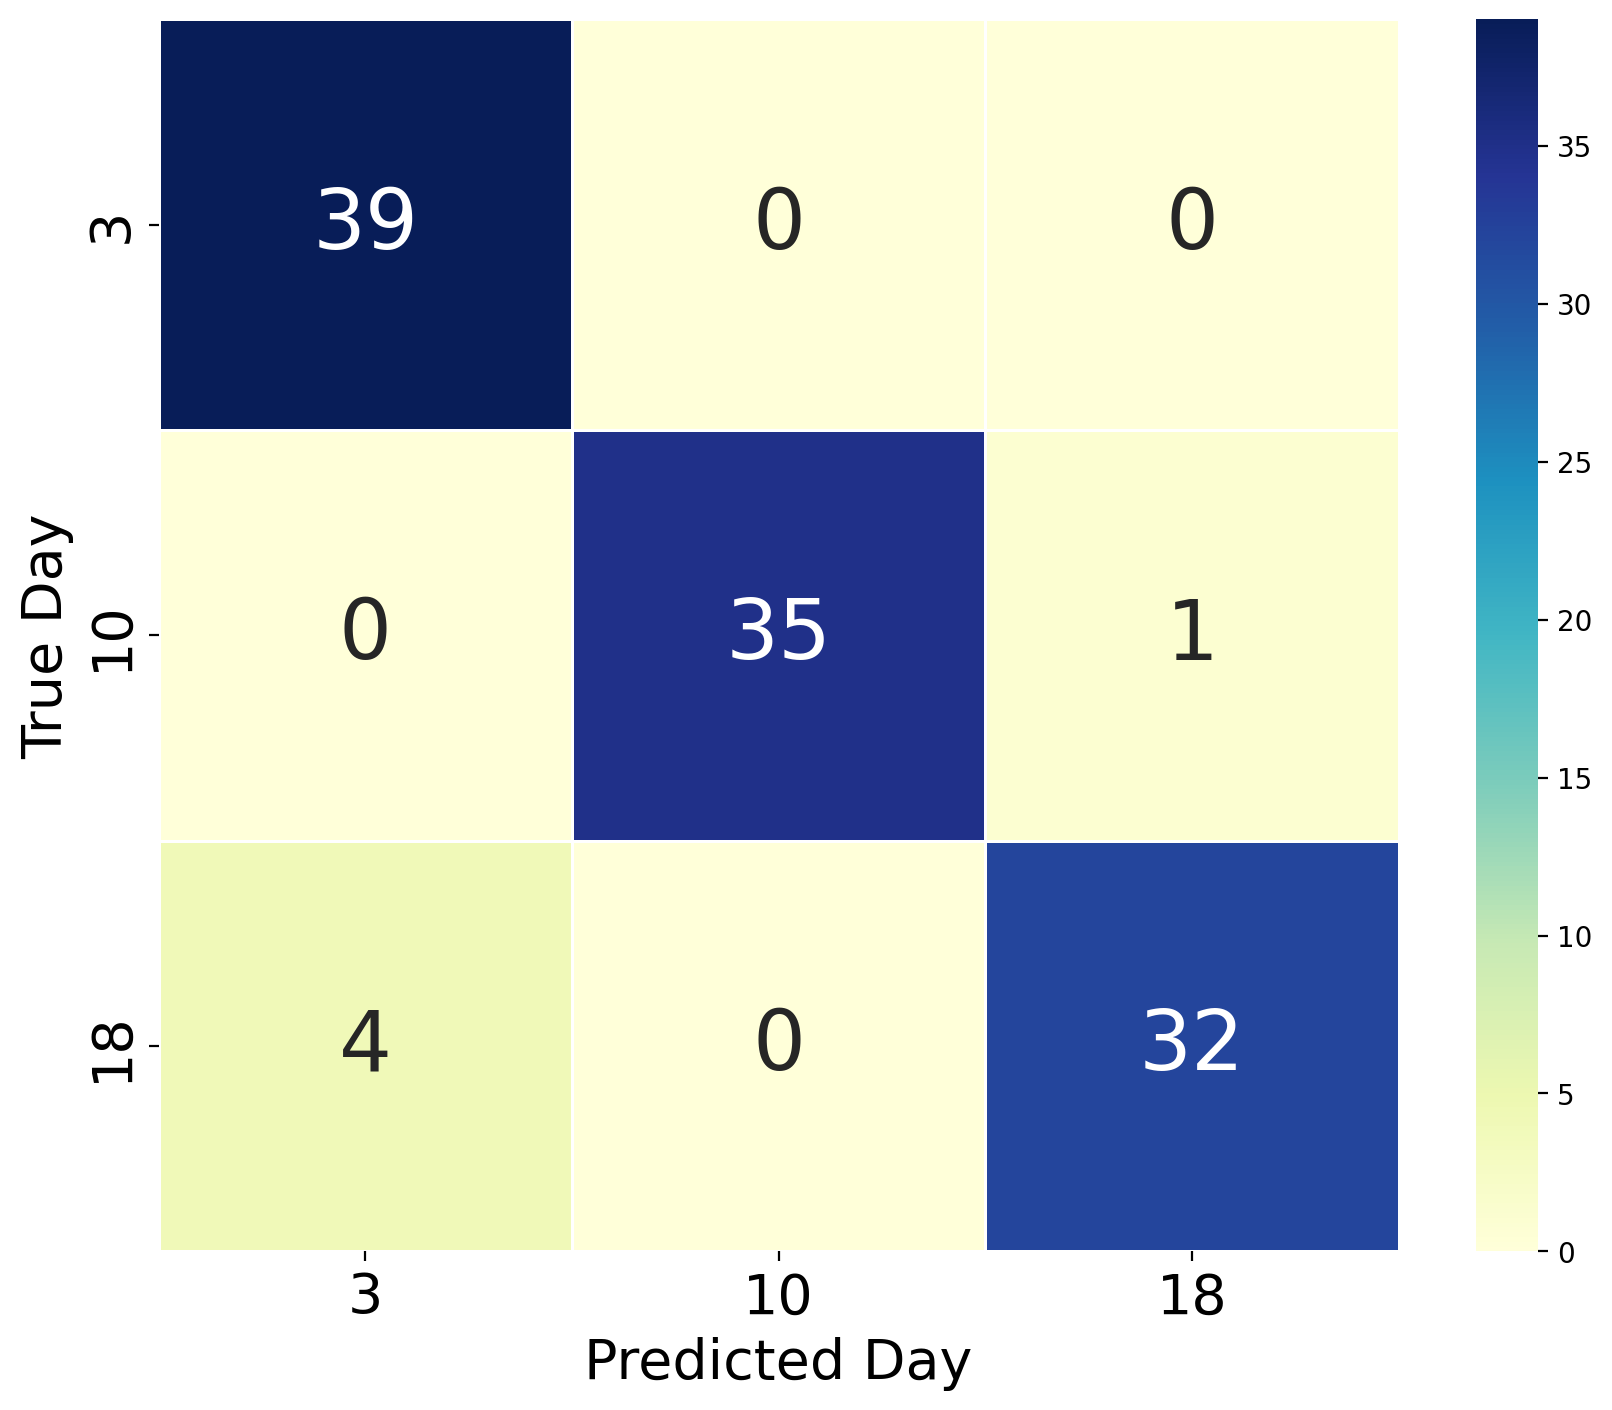

In [135]:
### Figure 3B ###
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Your existing code to get pred_labels and true_labels
pred_labels = pred_test_last.argmax(1).cpu().numpy()
true_labels = label_test_last.cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Define class labels (adjust this list to match your actual labels)
class_labels = [3, 10, 18]
# Plot confusion matrix
plt.figure(figsize=(10, 8))
#sns.set(font_scale=1.5)  # Adjust to increase the size of the annotations
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=.5, 
            xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 30})
#sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=.5, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Day", fontsize=20)  # Adjust to increase the size of the x-axis label
plt.ylabel("True Day", fontsize=20)  # Adjust to increase the size of the y-axis label
plt.xticks(fontsize=20)  # Adjust to increase the size of x-axis tick labels
plt.yticks(fontsize=20)  # Adjust to increase the size of y-axis tick labels
plt.show()

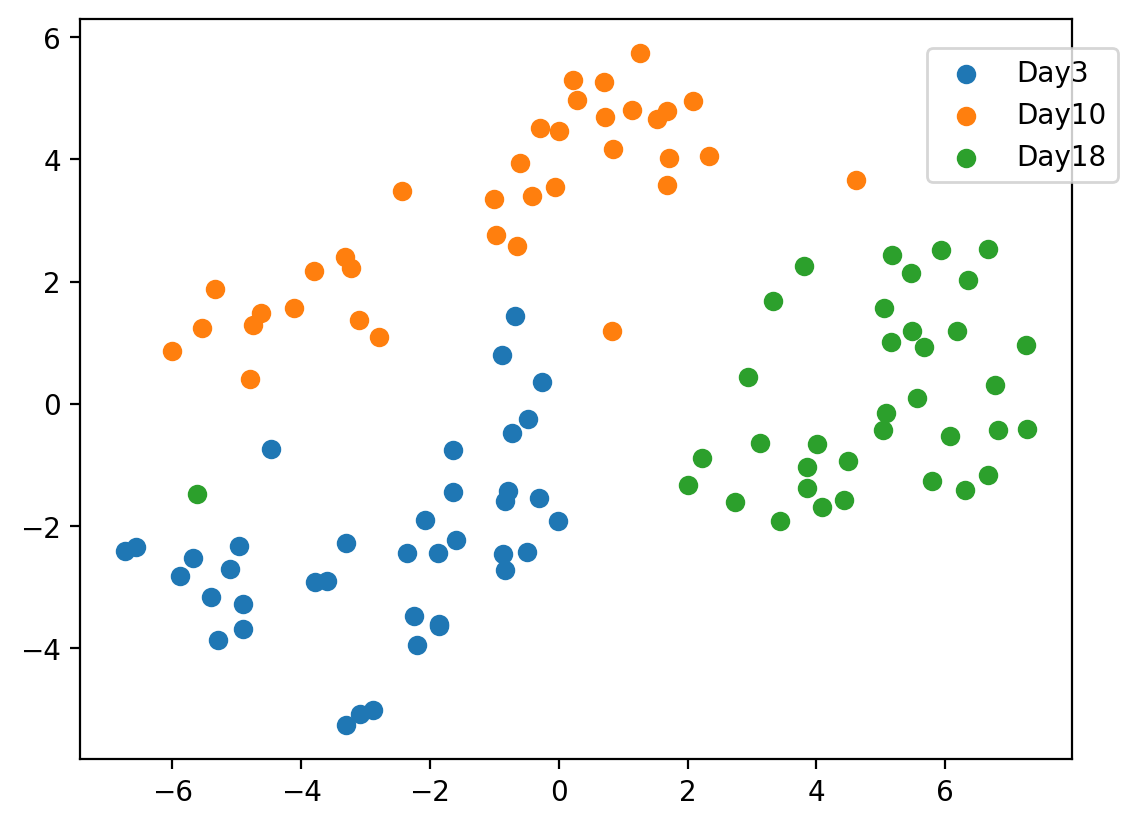

In [136]:
### Figure 3C ###
from sklearn.manifold import TSNE
with torch.no_grad():
    dnn_feature_test = feature_extractor(data_test).numpy()

# Set the number of components to 2 for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
feature_test_embedded_tsne = tsne.fit_transform(dnn_feature_test)

fig, ax = plt.subplots()
for ii in range(len(ages)):  # Adjust the range based on your labels
    idx = np.where(label_test == ii)
    feature_now = feature_test_embedded_tsne[idx[0]]
    ax.scatter(feature_now[:, 0], feature_now[:, 1], label=str(ages[ii]))

ax.legend()
plt.legend(loc='upper left', bbox_to_anchor=(0.84,0.98))
plt.show()


In [137]:
### Load Figure 3 data for regression ###
loaded = np.load("data/Figure_3_regression.npz")

data_train = loaded["data_train"]
data_test = loaded["data_test"]
label_train = loaded["label_train"]
label_test = loaded["label_test"]
spectral_range = loaded["spectral_range"]

In [138]:
#### Figure 3 regression model ####
device = torch.device('cpu')

## data ##
data_train = torch.tensor(data_train, dtype=torch.float32).to(device)
data_test = torch.tensor(data_test, dtype=torch.float32).to(device)

label_train = torch.tensor(label_train, dtype=torch.float32).to(device)
label_test = torch.tensor(label_test, dtype=torch.float32).to(device)

## model ##
hidden = [nn.Linear(dim_hidden, dim_hidden), nn.ReLU()] * num_layers
feature_extractor = nn.Sequential(nn.Linear(data_train.shape[1], dim_hidden), nn.ReLU(), *hidden).to(device)

model = nn.Sequential(
    feature_extractor,
    nn.Linear(dim_hidden, 1)
).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

## Initialize best model tracking
best_r2_test = -float('inf')
best_model_state = None

## full-batch training
for epoch in np.arange(num_epochs):
    
    pred = model(data_train).reshape(-1)
    loss = loss_fn(pred, label_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 999 or epoch == num_epochs - 1:
        # Train metrics
        loss_train = loss.item()
        R_train = (calculate_r2(pred, label_train).item())**0.5
        RMSE_train = calculate_RMSE(pred, label_train).item()

        # Test metrics
        pred_test = model(data_test).reshape(-1)
        R_test = (calculate_r2(pred_test, label_test).item())**0.5
        RMSE_test = calculate_RMSE(pred_test, label_test).item()

        print("Epoch = %d | Loss_train: %.4f | R_train: %.4f | RMSE_train: %.4f | R_test: %.4f | RMSE_test: %.4f" % (
            epoch, loss_train, R_train, RMSE_train, R_test, RMSE_test))

        # Save the best model by R²
        if R_test > best_r2_test:
            best_r2_test = R_test
            best_model_state = model.state_dict()

# Save best model
torch.save(best_model_state, "figure_3_regression_model.pth")

# Load best model for evaluation (optional)
model.load_state_dict(torch.load("figure_3_regression_model.pth"))
model.eval()
with torch.no_grad():
    pred_test_final = model(data_test).reshape(-1)
    actual_test_final = label_test

Epoch = 999 | Loss_train: 10.3087 | R_train: 0.8547 | RMSE_train: 3.2107 | R_test: 0.7828 | RMSE_test: 3.7839
Epoch = 1999 | Loss_train: 0.8382 | R_train: 0.9890 | RMSE_train: 0.9155 | R_test: 0.9589 | RMSE_test: 1.7250
Epoch = 2999 | Loss_train: 0.7391 | R_train: 0.9903 | RMSE_train: 0.8597 | R_test: 0.9604 | RMSE_test: 1.6945
Epoch = 3999 | Loss_train: 1.0915 | R_train: 0.9856 | RMSE_train: 1.0448 | R_test: 0.9567 | RMSE_test: 1.7694
Epoch = 4999 | Loss_train: 0.1390 | R_train: 0.9982 | RMSE_train: 0.3728 | R_test: 0.9681 | RMSE_test: 1.5241
Epoch = 5999 | Loss_train: 1.0107 | R_train: 0.9867 | RMSE_train: 1.0053 | R_test: 0.9675 | RMSE_test: 1.5373
Epoch = 6999 | Loss_train: 0.6247 | R_train: 0.9918 | RMSE_train: 0.7904 | R_test: 0.9659 | RMSE_test: 1.5739
Epoch = 7999 | Loss_train: 0.3100 | R_train: 0.9959 | RMSE_train: 0.5568 | R_test: 0.9690 | RMSE_test: 1.5030
Epoch = 8999 | Loss_train: 0.3389 | R_train: 0.9956 | RMSE_train: 0.5821 | R_test: 0.9686 | RMSE_test: 1.5122
Epoch = 99

/var/folders/1n/d01xw0td6gs9hhffxkqqydy80000gn/T/ipykernel_53225/2613293834.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("figure_3_r

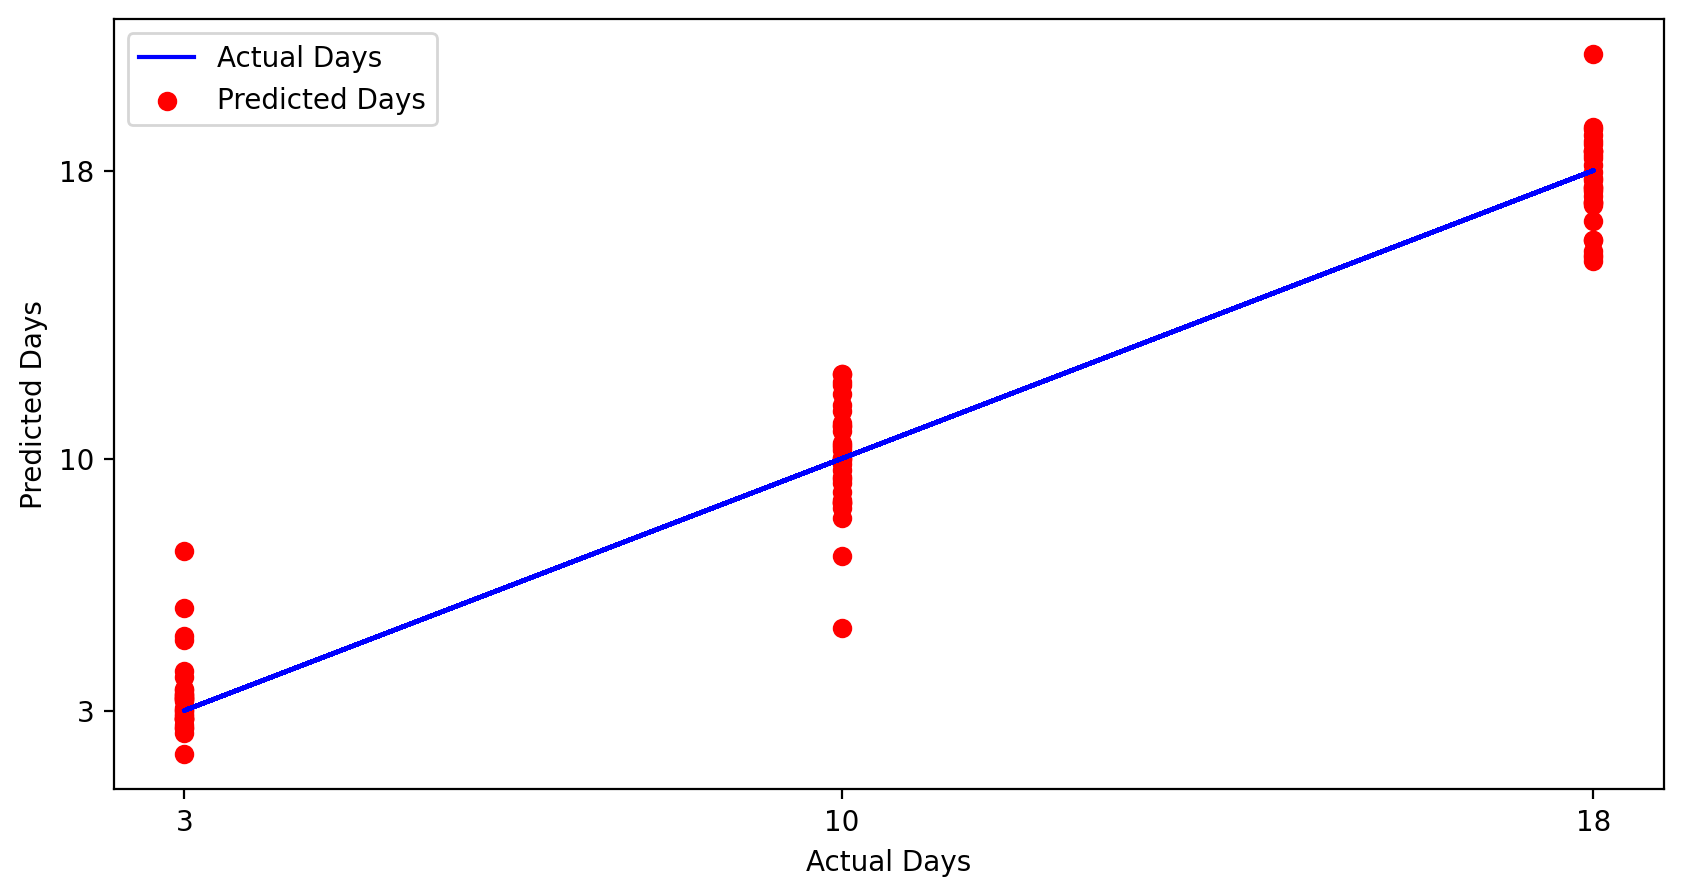

In [115]:
### Figure 3D ###
import pandas as pd
import matplotlib.pyplot as plt

# Convert tensors to NumPy arrays if needed
actual_np = actual_test_final.cpu().numpy()
predicted_np = pred_test_final.cpu().numpy()

# Create DataFrame
df_results = pd.DataFrame({
    'Actual Days': actual_np,
    'Predicted Days': predicted_np
})

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_results['Actual Days'], df_results['Actual Days'], label='Actual Days', linestyle='-', color='blue')
plt.scatter(df_results['Actual Days'], df_results['Predicted Days'], label='Predicted Days', color='red')
plt.xlabel('Actual Days')
plt.ylabel('Predicted Days')
plt.yticks([3, 10, 18])
plt.xticks([3, 10, 18])
#plt.title('Actual vs Predicted Days for the Last Epoch')
plt.legend()
plt.show()

In [139]:
### Figure 4 classification data load ###
loaded = np.load("data/Figure_4_classification.npz")
data_train = loaded["data_train"]
data_test = loaded["data_test"]
label_train = loaded["label_train"]
label_test = loaded["label_test"]
spectral_range = loaded["spectral_range"]

In [140]:
#### Figure 4 classification analysis parameters ####
dim_hidden = 100 # num of hidden units in the neural network classifier
num_layers = 2 # num of hidden layers
num_epochs = 10000
ages = ['Day1', 'Day3', 'Day7', 'Day10', 'Day14', 'Day18', 'Day21']
num_classes = len(ages)

In [141]:
#### Figure 4 classification model ####
import torch
import numpy as np
from torch import nn

device = torch.device('cpu')

## data ##
data_train = torch.tensor(data_train, dtype=torch.float32).to(device)
data_test = torch.tensor(data_test, dtype=torch.float32).to(device)

label_train = torch.tensor(label_train, dtype=torch.int64).to(device)
label_test = torch.tensor(label_test, dtype=torch.int64).to(device)

## model ##
hidden = [nn.Linear(dim_hidden, dim_hidden), nn.ReLU()] * num_layers

feature_extractor = nn.Sequential(nn.Linear(data_train.shape[1], dim_hidden), nn.ReLU(), *hidden).to(device)

model = nn.Sequential(
    feature_extractor,
    nn.Linear(dim_hidden, num_classes)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

best_acc_test = 0.0  # Initialize the best test accuracy
best_model_state = None  # Placeholder for the best model state

## full-batch training
for epoch in np.arange(num_epochs):
    
    # compute prediction error
    pred = model(data_train)
    loss = loss_fn(pred, label_train)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 999:
        # training
        loss_train = loss.item()
        num_correct_train = (pred.argmax(1) == label_train).type(torch.float).sum().item()
        acc_train = num_correct_train / data_train.shape[0]
        
        # testing
        pred_test = model(data_test)
        num_correct_test = (pred_test.argmax(1) == label_test).type(torch.float).sum().item()
        acc_test = num_correct_test / data_test.shape[0]        

        # Save the best model
        if acc_test > best_acc_test:
            best_acc_test = acc_test
            best_model_state = model.state_dict()  # Save model's parameters

        print("Epoch = %d| Loss_train: %.4f | Acc_train: %.2f | Acc_test: %.2f" % (epoch, loss_train, acc_train, acc_test))

# Save the best model to a file
torch.save(best_model_state, "figure_4_classification_model.pth")

# Load the best model for evaluation (optional)
model.load_state_dict(torch.load("figure_4_classification_model.pth"))
model.eval()
with torch.no_grad():
    pred_test_last = model(data_test)
    label_test_last = label_test

Epoch = 999| Loss_train: 0.0001 | Acc_train: 1.00 | Acc_test: 0.80
Epoch = 1999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.79
Epoch = 2999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.78
Epoch = 3999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.78
Epoch = 4999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.78
Epoch = 5999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.78
Epoch = 6999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.79
Epoch = 7999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.79
Epoch = 8999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.79
Epoch = 9999| Loss_train: 0.0000 | Acc_train: 1.00 | Acc_test: 0.79


/var/folders/1n/d01xw0td6gs9hhffxkqqydy80000gn/T/ipykernel_53225/25897522.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("figure_4_cla

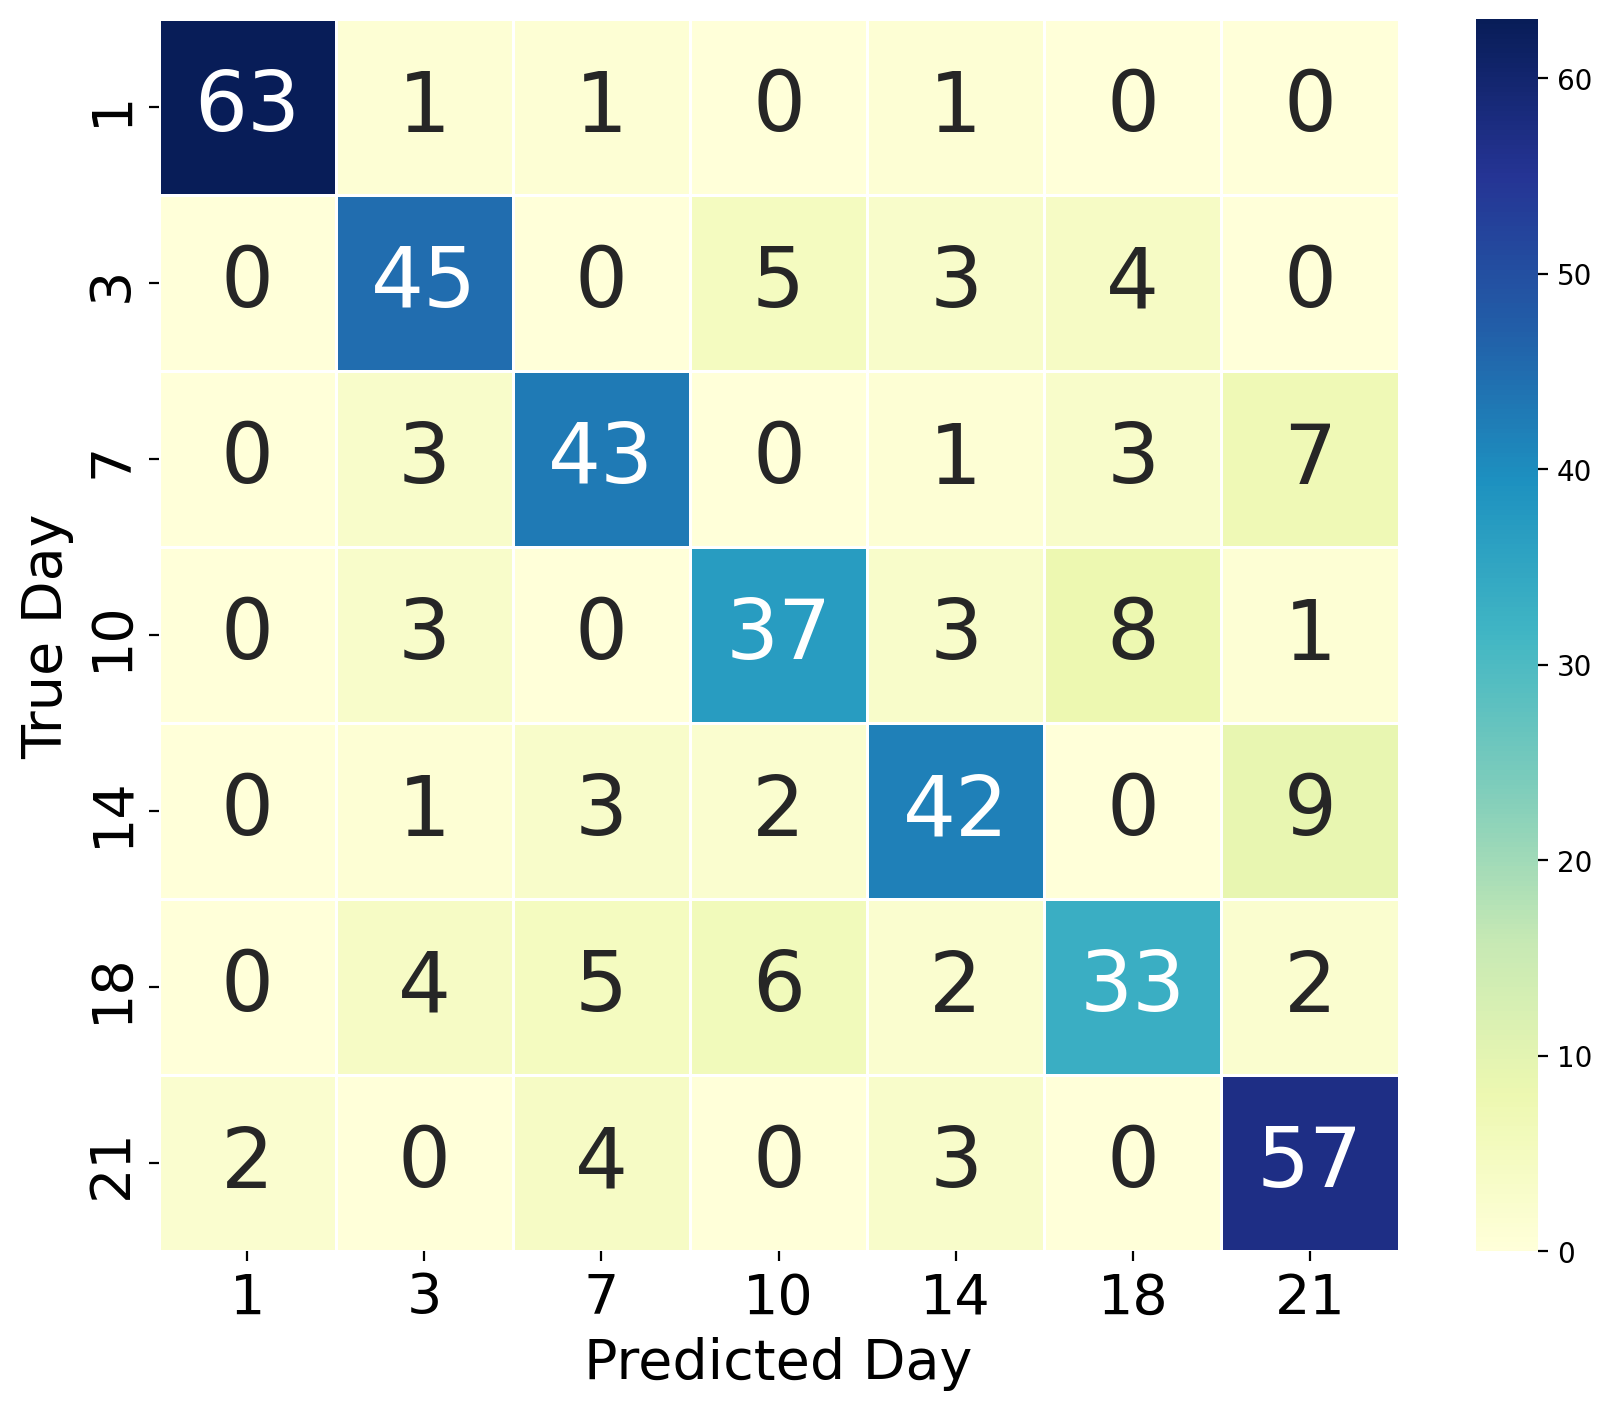

In [142]:
### Figure 4A ###
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Your existing code to get pred_labels and true_labels
pred_labels = pred_test_last.argmax(1).cpu().numpy()
true_labels = label_test_last.cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Define class labels (adjust this list to match your actual labels)
class_labels = [1,3,7,10,14,18,21]
# Plot confusion matrix
plt.figure(figsize=(10, 8))
#sns.set(font_scale=1.5)  # Adjust to increase the size of the annotations
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=.5, 
            xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 30})
#sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=.5, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Day", fontsize=20)  # Adjust to increase the size of the x-axis label
plt.ylabel("True Day", fontsize=20)  # Adjust to increase the size of the y-axis label
plt.xticks(fontsize=20)  # Adjust to increase the size of x-axis tick labels
plt.yticks(fontsize=20)  # Adjust to increase the size of y-axis tick labels
plt.show()

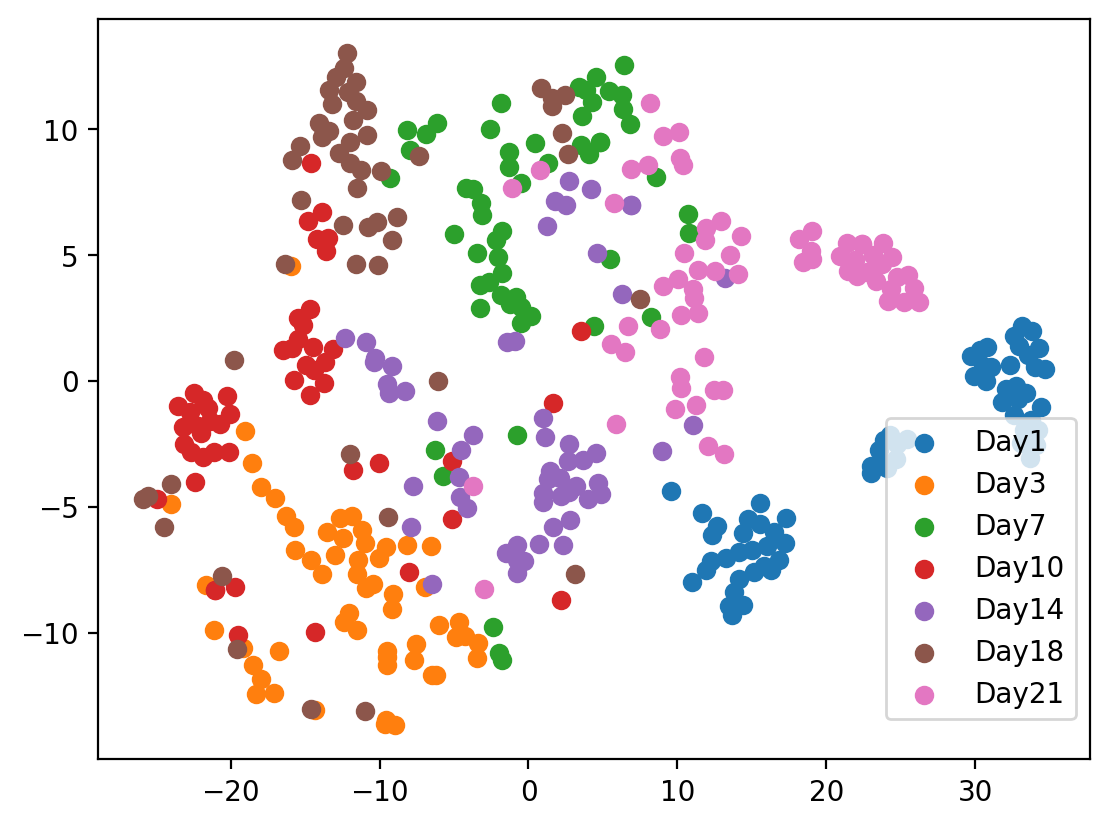

In [143]:
### Figure 4B ###
from sklearn.manifold import TSNE
with torch.no_grad():
    dnn_feature_test = feature_extractor(data_test).numpy()

# Set the number of components to 2 for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
feature_test_embedded_tsne = tsne.fit_transform(dnn_feature_test)

fig, ax = plt.subplots()
for ii in range(len(ages)):  # Adjust the range based on your labels
    idx = np.where(label_test == ii)
    feature_now = feature_test_embedded_tsne[idx[0]]
    ax.scatter(feature_now[:, 0], feature_now[:, 1], label=str(ages[ii]))

ax.legend()
plt.legend(loc='upper left', bbox_to_anchor=(0.78,0.48))
plt.show()


In [144]:
### Load Figure 4 data for regression ###
loaded = np.load("data/Figure_4_regression.npz")
data_train = loaded["data_train"]
data_test = loaded["data_test"]
label_train = loaded["label_train"]
label_test = loaded["label_test"]
spectral_range = loaded["spectral_range"]

In [145]:
#### Figure 4 regression model ###
device = torch.device('cpu')

# Data to tensor
data_train = torch.tensor(data_train, dtype=torch.float32).to(device)
data_test = torch.tensor(data_test, dtype=torch.float32).to(device)
label_train = torch.tensor(label_train, dtype=torch.float32).to(device)
label_test = torch.tensor(label_test, dtype=torch.float32).to(device)

# Model
hidden = [nn.Linear(dim_hidden, dim_hidden), nn.ReLU()] * num_layers
feature_extractor = nn.Sequential(nn.Linear(data_train.shape[1], dim_hidden), nn.ReLU(), *hidden).to(device)
model = nn.Sequential(feature_extractor, nn.Linear(dim_hidden, 1)).to(device)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Track best model
best_r2_test = -float('inf')
best_model_state = None

for epoch in np.arange(num_epochs):
    pred = model(data_train).reshape(-1)
    loss = loss_fn(pred, label_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 999 or epoch == num_epochs - 1:
        # Train metrics
        R_train_raw = calculate_r2(pred, label_train).item()
        R_train = np.sqrt(max(R_train_raw, 0))
        RMSE_train = calculate_RMSE(pred, label_train).item()

        # Test metrics
        pred_test = model(data_test).reshape(-1)
        R_test_raw = calculate_r2(pred_test, label_test).item()
        R_test = np.sqrt(max(R_test_raw, 0))
        RMSE_test = calculate_RMSE(pred_test, label_test).item()

        print("Epoch = %d | R_train: %.4f | RMSE_train: %.4f | R_test: %.4f | RMSE_test: %.4f" %
              (epoch, R_train, RMSE_train, R_test, RMSE_test))

        # Save best model
        if R_test_raw > best_r2_test:
            best_r2_test = R_test_raw
            best_model_state = model.state_dict()

# Save best model
torch.save(best_model_state, "figure_4_regression_model.pth")

# Reload and evaluate final model
model.load_state_dict(torch.load("figure_4_regression_model.pth"))
model.eval()
with torch.no_grad():
    pred_test_final = model(data_test).reshape(-1)
    actual_test_final = label_test

    # Final metrics
    R_final_raw = calculate_r2(pred_test_final, actual_test_final).item()
    R_final = np.sqrt(max(R_final_raw, 0))
    RMSE_final = calculate_RMSE(pred_test_final, actual_test_final).item()

    print("\n🧪 Final Evaluation on Best Model:")
    print("R (sqrt R²) = %.4f | RMSE = %.4f" % (R_final, RMSE_final))

Epoch = 999 | R_train: 0.9940 | RMSE_train: 0.7786 | R_test: 0.9032 | RMSE_test: 3.1377
Epoch = 1999 | R_train: 0.9996 | RMSE_train: 0.2095 | R_test: 0.9075 | RMSE_test: 3.0706
Epoch = 2999 | R_train: 0.9995 | RMSE_train: 0.2238 | R_test: 0.9061 | RMSE_test: 3.0932
Epoch = 3999 | R_train: 0.9998 | RMSE_train: 0.1470 | R_test: 0.9091 | RMSE_test: 3.0456
Epoch = 4999 | R_train: 0.9998 | RMSE_train: 0.1465 | R_test: 0.9087 | RMSE_test: 3.0515
Epoch = 5999 | R_train: 0.9999 | RMSE_train: 0.0964 | R_test: 0.9101 | RMSE_test: 3.0292
Epoch = 6999 | R_train: 0.9998 | RMSE_train: 0.1496 | R_test: 0.9100 | RMSE_test: 3.0305
Epoch = 7999 | R_train: 0.9886 | RMSE_train: 1.0701 | R_test: 0.9061 | RMSE_test: 3.0929
Epoch = 8999 | R_train: 0.9999 | RMSE_train: 0.1098 | R_test: 0.9078 | RMSE_test: 3.0663
Epoch = 9999 | R_train: 0.9999 | RMSE_train: 0.0754 | R_test: 0.9077 | RMSE_test: 3.0676

🧪 Final Evaluation on Best Model:
R (sqrt R²) = 0.9077 | RMSE = 3.0676


/var/folders/1n/d01xw0td6gs9hhffxkqqydy80000gn/T/ipykernel_53225/3969154942.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("figure_4_r

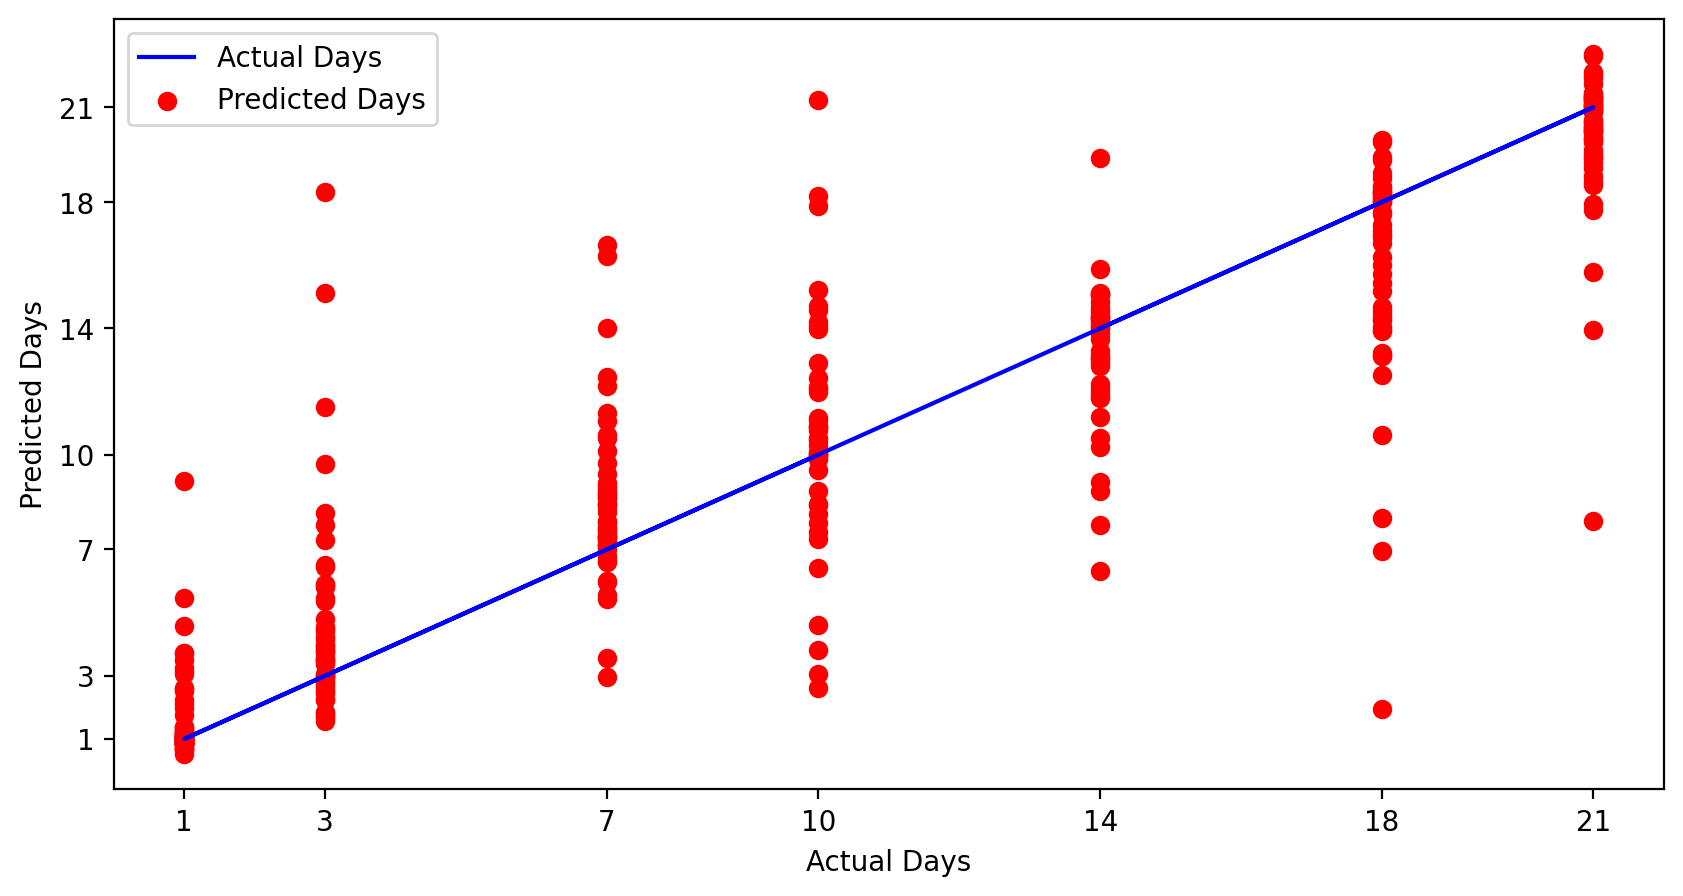

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert tensors to NumPy arrays if needed
actual_np = actual_test_final.cpu().numpy()
predicted_np = pred_test_final.cpu().numpy()

# Create DataFrame
df_results = pd.DataFrame({
    'Actual Days': actual_np,
    'Predicted Days': predicted_np
})

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_results['Actual Days'], df_results['Actual Days'], label='Actual Days', linestyle='-', color='blue')
plt.scatter(df_results['Actual Days'], df_results['Predicted Days'], label='Predicted Days', color='red')
plt.xlabel('Actual Days')
plt.ylabel('Predicted Days')
plt.yticks([1, 3, 7, 10, 14, 18, 21])
plt.xticks([1, 3, 7, 10, 14, 18, 21])
#plt.title('Actual vs Predicted Days for the Last Epoch')
plt.legend()
plt.show()